# FID

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [ ]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), AccelerateCB()]

In [ ]:
set_seed(42)
epochs = 5

In [ ]:
from timm import models

In [ ]:
lr = 4e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = models.resnet10t(in_chans=1, num_classes=10)
opt_func = partial(optim.AdamW, eps=1e-5)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

accuracy,loss,epoch,train
0.793,0.582,0,train
0.756,0.826,0,eval
0.873,0.342,1,train
0.800,0.545,1,eval
0.903,0.257,2,train
0.900,0.281,2,eval
0.925,0.200,3,train
0.911,0.245,3,eval
0.941,0.157,4,train
0.921,0.223,4,eval


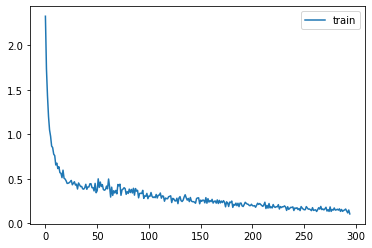

In [ ]:
learn.fit(epochs)

In [ ]:
mdl_path = Path('models')

In [ ]:
torch.save(learn.model.state_dict(), mdl_path/'fashion_rn10t.sd')

In [ ]:
learn.model.load_state_dict(torch.load(mdl_path/'fashion_rn10t.sd'))

<All keys matched successfully>

In [ ]:
xb,yb = b = next(iter(dls.train))

In [ ]:
pred_dl = DataLoaders([b],[b])

In [ ]:
def append_outp(hook, mod, inp, outp):
    if not hasattr(hook,'outp'): hook.outp = []
    hook.outp.append(to_cpu(outp))

In [ ]:
hcb = HooksCallback(append_outp, mods=[learn.model.layer4], on_valid=True)

In [ ]:
learn.dls = pred_dl

In [ ]:
learn.fit(1, train=False, cbs=[hcb])

accuracy,loss,epoch,train
0.945,0.129,0,eval


In [ ]:
feats = hcb.hooks[0].outp[0].float()

In [ ]:
feats.shape

torch.Size([1024, 512, 1, 1])

In [ ]:
m = feats.mean(0)

In [ ]:
torch.cov(feats.reshape(len(feats),-1)).shape

torch.Size([1024, 1024])

### Export -

In [ ]:
import nbdev; nbdev.nbdev_export()